# Importar librerias

In [1]:
import torch
print(torch.cuda.is_available())  # True
print(torch.cuda.get_device_name(0))  # NVIDIA GeForce RTX 3050

True
NVIDIA GeForce RTX 3050 Laptop GPU


In [2]:
#pip install opencv-python


In [3]:
#pip install torch torchvision

In [4]:
import os, math, random, pathlib
from typing import Tuple
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms as T

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Dimensionar las imagenes

In [6]:
from torchvision import transforms

# Transformaciones para entrenamiento (aumentos + normalización)
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0,
                            translate=(0.05, 0.05)),  # equivalente a width/height_shift
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

# Transformaciones para validación y test (solo reescalado + normalización)
val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

# Inicio del codigo

In [7]:
# ----------------- Config -----------------
BASE_DIR   = "002_cancer"
TRAIN_DIR  = os.path.join(BASE_DIR, "train")
VAL_DIR    = os.path.join(BASE_DIR, "val")
TEST_DIR   = os.path.join(BASE_DIR, "test")

CLASSES = 2
BATCH   = 32
ROWS = COLS = 224
INPUT_CH = 3
SEED         = 42
EPOCHS       = 25
TEST_MAX_SAMPLES = 3000

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
torch.manual_seed(SEED)


Using device: cuda


In [8]:
# ===== Datasets & Dataloaders =====
from torch.utils.data import random_split

# Comprobación de carpetas
for p in [TRAIN_DIR, TEST_DIR]:
    assert os.path.isdir(os.path.join(p, "Benign")),    f"Falta {p}/Benign"
    assert os.path.isdir(os.path.join(p, "Malignant")), f"Falta {p}/Malignant"

use_explicit_val = os.path.isdir(VAL_DIR) and all(
    os.path.isdir(os.path.join(VAL_DIR, c)) for c in ["Benign", "Malignant"]
)

if use_explicit_val:
    train_ds = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
    val_ds   = datasets.ImageFolder(VAL_DIR,   transform=val_test_transforms)
else:
    # Split desde TRAIN -> (train, val)
    full_train = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
    val_ratio  = 0.2
    n_total    = len(full_train)
    n_val      = int(n_total * val_ratio)
    n_train    = n_total - n_val
    train_ds, val_ds = random_split(
        full_train, [n_train, n_val],
        generator=torch.Generator().manual_seed(SEED)
    )

test_ds  = datasets.ImageFolder(TEST_DIR, transform=val_test_transforms)

NUM_WORKERS = 0 if os.name == "nt" else 4
train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=(device=="cuda"))
val_loader   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=(device=="cuda"))
test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=(device=="cuda"))

# Mapeo de clases
if use_explicit_val:
    class_to_idx = datasets.ImageFolder(TRAIN_DIR).class_to_idx
else:
    class_to_idx = train_ds.dataset.class_to_idx if hasattr(train_ds, "dataset") else datasets.ImageFolder(TRAIN_DIR).class_to_idx
idx_to_class = {v:k for k,v in class_to_idx.items()}
print("Clases:", class_to_idx)
print(f"Train={len(train_ds)} | Val={len(val_ds)} | Test={len(test_ds)}")


Clases: {'Benign': 0, 'Malignant': 1}
Train=9504 | Val=2375 | Test=2000


In [9]:
# ===== Modelo básico (CNN pequeña) =====
import torch.nn as nn
import torch.nn.functional as F

class BasicCNN(nn.Module):
    def __init__(self, in_ch=3, num_classes=2):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_ch, 32, kernel_size=3, padding=1),  # [B,32,224,224]
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                                  # [B,32,112,112]

            nn.Conv2d(32, 64, kernel_size=3, padding=1),      # [B,64,112,112]
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                                  # [B,64,56,56]

            nn.Conv2d(64, 128, kernel_size=3, padding=1),     # [B,128,56,56]
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                                  # [B,128,28,28]

            nn.Conv2d(128, 256, kernel_size=3, padding=1),    # [B,256,28,28]
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                                  # [B,256,14,14]
        )
        self.pool = nn.AdaptiveAvgPool2d((1,1))               # [B,256,1,1]
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = self.classifier(x)
        return x

model = BasicCNN(in_ch=INPUT_CH, num_classes=CLASSES).to(device)
print(model)


BasicCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, aff

In [10]:
# ===== Entrenamiento =====
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=2)

# Bandera para AMP: True solo si hay GPU
USE_AMP = (device == "cuda")
scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)

best_val_loss = float("inf")
best_path = "basic_cnn_best.pt"
patience = 5
epochs_no_improve = 0

def run_epoch(loader, train_mode=True):
    if train_mode:
        model.train()
    else:
        model.eval()
    total, correct, running = 0, 0, 0.0

    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        if train_mode:
            optimizer.zero_grad(set_to_none=True)

        if USE_AMP:
            with torch.cuda.amp.autocast():
                logits = model(xb)
                loss   = criterion(logits, yb)
        else:
            logits = model(xb)
            loss   = criterion(logits, yb)

        if train_mode:
            if USE_AMP:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()

        running += loss.item() * xb.size(0)
        pred = logits.argmax(1)
        total += yb.size(0)
        correct += (pred == yb).sum().item()

    return running/total, correct/total


C:\Users\Usuario\AppData\Local\Temp\ipykernel_16880\772398189.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)


In [11]:
# Historial para gráficas
hist = {
    "epoch": [],
    "train_loss": [],
    "train_acc": [],
    "val_loss":   [],
    "val_acc":    []
}

In [12]:
# Si ya tienes class_to_idx, omite esto.
try:
    class_to_idx
except NameError:
    from torchvision import datasets
    class_to_idx = datasets.ImageFolder(TRAIN_DIR).class_to_idx

idx_to_class = {v:k for k,v in class_to_idx.items()}
malignant_index = class_to_idx.get("Malignant", 1)  # por si la carpeta se llama distinto, ajusta aquí
print("class_to_idx:", class_to_idx, "| malignant_index:", malignant_index)

class_to_idx: {'Benign': 0, 'Malignant': 1} | malignant_index: 1


In [13]:
@torch.no_grad()
def evaluate_with_fn(loader):
    model.eval()
    total, correct, running = 0, 0, 0.0
    fn_total = 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        if USE_AMP:
            with torch.cuda.amp.autocast():
                logits = model(xb)
                loss   = criterion(logits, yb)
        else:
            logits = model(xb)
            loss   = criterion(logits, yb)

        running += loss.item() * xb.size(0)
        preds = logits.argmax(1)

        total += yb.size(0)
        correct += (preds == yb).sum().item()

        # FN = verdaderos Malignant predichos como NO-Malignant
        fn_total += ((preds != malignant_index) & (yb == malignant_index)).sum().item()

    return running/total, correct/total, fn_total

In [14]:
best_val_loss = float("inf")
best_val_fn   = float("inf")     # criterio principal
best_path     = "basic_cnn_minFN.pt"
patience      = 5
epochs_no_improve = 0

for epoch in range(1, EPOCHS+1):
    # ---- TRAIN ----
    tr_loss, tr_acc = run_epoch(train_loader, train_mode=True)

    # ---- VAL (cada época; al optimizar FN conviene validar siempre) ----
    va_loss, va_acc, va_fn = evaluate_with_fn(val_loader)
    scheduler.step(va_loss)

    # --- guardar historial ---
    hist["epoch"].append(epoch)
    hist["train_loss"].append(tr_loss)
    hist["train_acc"].append(tr_acc)
    hist["val_loss"].append(va_loss)
    hist["val_acc"].append(va_acc)

    print(f"[{epoch:02d}/{EPOCHS}] "
          f"train_loss={tr_loss:.4f} acc={tr_acc:.3f} | "
          f"val_loss={va_loss:.4f} acc={va_acc:.3f} | "
          f"val_FN={va_fn} | "
          f"LR={optimizer.param_groups[0]['lr']:.6f}",
          flush=True)

    # ---- guardar mejor por FN; desempate por menor val_loss ----
    improved = (va_fn < best_val_fn) or ((va_fn == best_val_fn) and (va_loss < best_val_loss - 1e-4))
    if improved:
        best_val_fn = va_fn
        best_val_loss = va_loss
        epochs_no_improve = 0
        torch.save({
            "model_state": model.state_dict(),
            "class_to_idx": class_to_idx,
            "malignant_index": malignant_index,
            "best_val_fn": best_val_fn,
            "best_val_loss": best_val_loss,
            "epoch": epoch
        }, best_path)
        print(f"✔️ Guardado mejor modelo (min FN): FN={best_val_fn}, loss={best_val_loss:.4f} -> {best_path}", flush=True)
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping (sin mejora en FN).", flush=True)
            break

C:\Users\Usuario\AppData\Local\Temp\ipykernel_16880\772398189.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\Usuario\AppData\Local\Temp\ipykernel_16880\2561163597.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[01/25] train_loss=0.4479 acc=0.785 | val_loss=0.3795 acc=0.822 | val_FN=185 | LR=0.001000
✔️ Guardado mejor modelo (min FN): FN=185, loss=0.3795 -> basic_cnn_minFN.pt
[02/25] train_loss=0.4004 acc=0.814 | val_loss=0.3514 acc=0.829 | val_FN=147 | LR=0.001000
✔️ Guardado mejor modelo (min FN): FN=147, loss=0.3514 -> basic_cnn_minFN.pt
[03/25] train_loss=0.3704 acc=0.829 | val_loss=0.3438 acc=0.851 | val_FN=191 | LR=0.001000
[04/25] train_loss=0.3493 acc=0.842 | val_loss=0.3302 acc=0.855 | val_FN=139 | LR=0.001000
✔️ Guardado mejor modelo (min FN): FN=139, loss=0.3302 -> basic_cnn_minFN.pt
[05/25] train_loss=0.3430 acc=0.848 | val_loss=0.3301 acc=0.868 | val_FN=204 | LR=0.001000
[06/25] train_loss=0.3227 acc=0.858 | val_loss=0.3180 acc=0.869 | val_FN=136 | LR=0.001000
✔️ Guardado mejor modelo (min FN): FN=136, loss=0.3180 -> basic_cnn_minFN.pt
[07/25] train_loss=0.3237 acc=0.859 | val_loss=0.3075 acc=0.873 | val_FN=137 | LR=0.001000
[08/25] train_loss=0.3173 acc=0.862 | val_loss=0.3223 a

In [15]:
# ===== Recargar mejor modelo =====
ckpt = torch.load(best_path, map_location=device)
model.load_state_dict(ckpt["model_state"])
class_to_idx = ckpt["class_to_idx"]
malignant_index = ckpt.get("malignant_index", class_to_idx.get("Malignant", 1))
idx_to_class = {v:k for k,v in class_to_idx.items()}
print(f"Mejor modelo cargado desde {best_path} | "
      f"FN={ckpt.get('best_val_fn')} loss={ckpt.get('best_val_loss')}", flush=True)

Mejor modelo cargado desde basic_cnn_minFN.pt | FN=101 loss=0.29195648604945135


C:\Users\Usuario\AppData\Local\Temp\ipykernel_16880\1308712078.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_path, map_location=device)


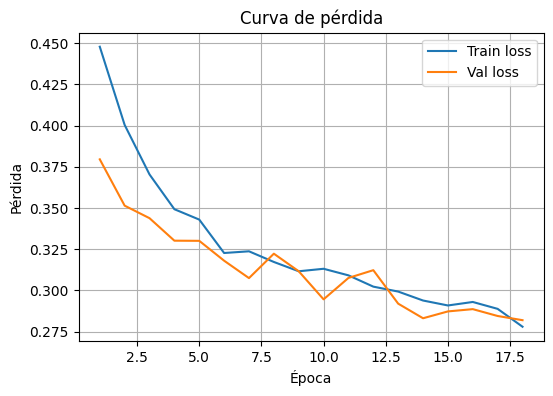

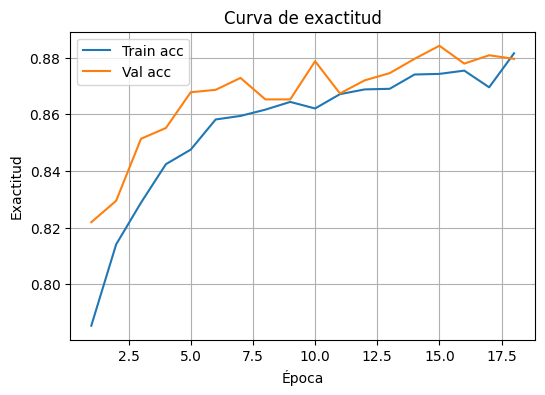

In [16]:
import matplotlib.pyplot as plt
import numpy as np

epochs = np.array(hist["epoch"])
tr_loss = np.array(hist["train_loss"], dtype=float)
tr_acc  = np.array(hist["train_acc"], dtype=float)
val_loss = np.array(hist["val_loss"], dtype=float)
val_acc  = np.array(hist["val_acc"], dtype=float)

plt.figure(figsize=(6,4))
plt.plot(epochs, tr_loss, label="Train loss")
plt.plot(epochs, val_loss, label="Val loss")
plt.xlabel("Época"); plt.ylabel("Pérdida"); plt.title("Curva de pérdida")
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs, tr_acc, label="Train acc")
plt.plot(epochs, val_acc, label="Val acc")
plt.xlabel("Época"); plt.ylabel("Exactitud"); plt.title("Curva de exactitud")
plt.legend(); plt.grid(True); plt.show()


C:\Users\Usuario\AppData\Local\Temp\ipykernel_16880\3271945181.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Test accuracy: 0.8825
              precision    recall  f1-score   support

      Benign       0.91      0.85      0.88      1000
   Malignant       0.86      0.92      0.89      1000

    accuracy                           0.88      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.88      0.88      0.88      2000



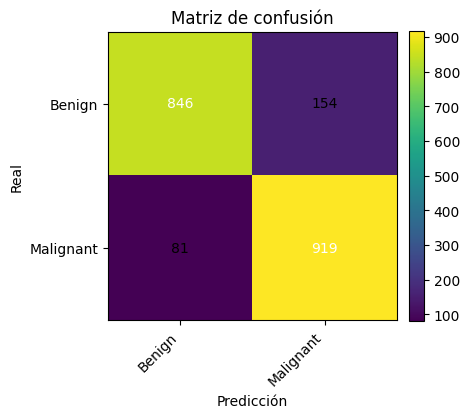

In [17]:
# pip install scikit-learn
from sklearn.metrics import confusion_matrix, classification_report

model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        if USE_AMP:
            with torch.cuda.amp.autocast():
                logits = model(xb)
        else:
            logits = model(xb)
        pred = logits.argmax(1).cpu()
        all_preds.append(pred)
        all_labels.append(yb)

all_preds  = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

test_acc = (all_preds == all_labels).mean()
print(f"Test accuracy: {test_acc:.4f}")
print(classification_report(all_labels, all_preds,
                            target_names=[idx_to_class[0], idx_to_class[1]]))

cm = confusion_matrix(all_labels, all_preds, labels=[0,1])

plt.figure(figsize=(4.8,4.8))
im = plt.imshow(cm, interpolation="nearest")
plt.title("Matriz de confusión"); plt.colorbar(im, fraction=0.046, pad=0.04)
tick_marks = np.arange(2)
plt.xticks(tick_marks, [idx_to_class[0], idx_to_class[1]], rotation=45, ha="right")
plt.yticks(tick_marks, [idx_to_class[0], idx_to_class[1]])
plt.xlabel("Predicción"); plt.ylabel("Real")

th = cm.max()/2.0 if cm.size > 0 else 0.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], "d"),
                 ha="center", va="center",
                 color="white" if cm[i, j] > th else "black")

plt.tight_layout(); plt.show()

In [18]:
import os
import csv
from pathlib import Path
import torch
import numpy as np
from PIL import Image
from sklearn.metrics import confusion_matrix

# ===== Parámetros de inferencia =====
# Umbral para decidir "Malignant" a partir de su probabilidad (por defecto 0.5)
MALIGNANT_IDX = class_to_idx.get("Malignant", 1)
THRESH = 0.5

# Dónde guardar resultados
OUT_DIR = Path("inference_results")
OUT_DIR.mkdir(parents=True, exist_ok=True)
CSV_PATH = OUT_DIR / "test_predictions.csv"

# (Opcional) Copiar imágenes a carpetas por acierto/error
SAVE_IMAGES = False
CORRECT_DIR = OUT_DIR / "pred_correct"
INCORR_DIR  = OUT_DIR / "pred_incorrect"
if SAVE_IMAGES:
    CORRECT_DIR.mkdir(exist_ok=True, parents=True)
    INCORR_DIR.mkdir(exist_ok=True, parents=True)

# ===== Pasada completa por test =====
model.eval()
all_probs_mal = []
all_preds_bin = []
all_labels    = []
all_paths     = []

# Para obtener rutas reales de test:
# si construiste test_loader = DataLoader(datasets.ImageFolder(...))
# entonces las rutas están en test_loader.dataset.samples (lista de (path, label))
test_samples = getattr(test_loader.dataset, "samples", None)

i_sample = 0
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        if USE_AMP:
            with torch.cuda.amp.autocast():
                logits = model(xb)
        else:
            logits = model(xb)

        probs = torch.softmax(logits, dim=1).cpu().numpy()            # [B, num_classes]
        p_mal = probs[:, MALIGNANT_IDX]                                # prob. de Malignant
        pred_bin = (p_mal >= THRESH).astype(np.int64)                  # 1 si Malignant

        all_probs_mal.append(p_mal)
        all_preds_bin.append(pred_bin)
        all_labels.append(yb.numpy())

        # rutas correspondientes a este batch
        if test_samples is not None:
            paths_batch = [test_samples[i_sample + k][0] for k in range(len(yb))]
            all_paths.extend(paths_batch)
            i_sample += len(yb)

all_probs_mal = np.concatenate(all_probs_mal)
all_preds_bin = np.concatenate(all_preds_bin)
all_labels    = np.concatenate(all_labels)

# ===== Métricas rápidas =====
acc = (all_preds_bin == all_labels).mean()
cm  = confusion_matrix(all_labels, all_preds_bin, labels=[0,1])  # [0=Begnin, 1=Malignant]
tn, fp, fn, tp = cm.ravel() if cm.size==4 else (0,0,0,0)
print(f"Test accuracy: {acc:.4f}")
print("Confusion matrix (rows: true, cols: pred) [0=Begnin, 1=Malignant]:\n", cm)
print(f"TP={tp} | FP={fp} | FN={fn} | TN={tn}")

# ===== Guardar CSV =====
# columnas: path, true_label_name, true_label_idx, pred_label_name, pred_label_idx, p_malignant, correct
header = ["path", "true_label_name", "true_label_idx",
          "pred_label_name", "pred_label_idx", "prob_malignant", "correct"]

with open(CSV_PATH, "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(header)
    for i in range(len(all_labels)):
        true_idx = int(all_labels[i])
        pred_idx = int(all_preds_bin[i])
        p_m      = float(all_probs_mal[i])

        true_name = idx_to_class[true_idx]
        pred_name = idx_to_class[pred_idx]
        correct   = int(pred_idx == true_idx)

        path_str = all_paths[i] if all_paths else ""   # si no hay paths, queda vacío
        writer.writerow([path_str, true_name, true_idx, pred_name, pred_idx, p_m, correct])

print(f"Predicciones guardadas en: {CSV_PATH}")

# ===== (Opcional) Copiar imágenes por acierto/error =====
if SAVE_IMAGES and all_paths:
    from shutil import copy2
    for i, p in enumerate(all_paths):
        dest = CORRECT_DIR if all_preds_bin[i] == all_labels[i] else INCORR_DIR
        # subcarpetas por predicción, útil para revisar errores de cada tipo
        pred_name = idx_to_class[int(all_preds_bin[i])]
        dest_cls = dest / pred_name
        dest_cls.mkdir(exist_ok=True, parents=True)
        try:
            copy2(p, dest_cls / Path(p).name)
        except Exception as e:
            print("No se pudo copiar:", p, "|", e)
    print(f"Imágenes copiadas a:\n - {CORRECT_DIR}\n - {INCORR_DIR}")

# ===== (Opcional) función para predecir 1 imagen suelta =====
def predict_image(path: str, transform=val_test_transforms, threshold=THRESH):
    """Devuelve (pred_name, prob_pred, prob_malignant, true_name_if_available)."""
    img = Image.open(path).convert("RGB")
    x = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        if USE_AMP:
            with torch.cuda.amp.autocast():
                logits = model(x)
        else:
            logits = model(x)
        probs = torch.softmax(logits, dim=1).cpu().numpy().squeeze()
    p_m = float(probs[MALIGNANT_IDX])
    pred_idx = int(p_m >= threshold)
    pred_name = idx_to_class[pred_idx]
    # intentar inferir etiqueta real a partir de la ruta (si está bajo .../Begnin o .../Malignant)
    true_name = None
    parts = Path(path).parts
    if "Begnin" in parts: true_name = "Begnin"
    if "Malignant" in parts: true_name = "Malignant"
    return pred_name, float(max(probs)), p_m, true_name

# Ejemplo:
# pred_name, prob_pred, p_mal, true_name = predict_image("002_cancer/test/Malignant/ejemplo.jpg")
# print(pred_name, prob_pred, p_mal, true_name)


C:\Users\Usuario\AppData\Local\Temp\ipykernel_16880\3651989914.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Test accuracy: 0.8825
Confusion matrix (rows: true, cols: pred) [0=Begnin, 1=Malignant]:
 [[846 154]
 [ 81 919]]
TP=919 | FP=154 | FN=81 | TN=846
Predicciones guardadas en: inference_results\test_predictions.csv


In [19]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import gradio as gr

# ============== Config ==============
CLASSES = ["Begnin", "Malignant"]      # orden de índices: 0, 1
MALIGNANT_IDX = 1                      # por convención
IMG_SIZE = 224
CHECKPOINT_PATH = os.getenv("MODEL_PATH", "models/basic_cnn_minFN.pt")

device = "cuda" if torch.cuda.is_available() else "cpu"
USE_AMP = (device == "cuda")

# ============== Modelo ==============
class BasicCNN(nn.Module):
    def __init__(self, in_ch=3, num_classes=2):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_ch, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = self.classifier(x)
        return x

# ============== Transforms ==============
# (equivalente a: Resize(224,224) + ToTensor + Normalize 0.5/0.5)
import torchvision.transforms as T
val_test_transforms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE), antialias=True),
    T.ToTensor(),
    T.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),
])

# ============== Carga de checkpoint ==============
model = BasicCNN(in_ch=3, num_classes=2).to(device)
ckpt = torch.load(CHECKPOINT_PATH, map_location=device)
state_key = "model_state" if "model_state" in ckpt else "model"
model.load_state_dict(ckpt[state_key])
model.eval()

# ============== Inferencia ==============
@torch.no_grad()
def predict(image: Image.Image, threshold: float = 0.50):
    """
    Devuelve: etiqueta, prob. de etiqueta predicha, prob. de Malignant, dict para Label/JSON
    """
    if image is None:
        return "No image", 0.0, 0.0, {"error": "No image"}

    x = val_test_transforms(image.convert("RGB")).unsqueeze(0).to(device)

    if USE_AMP:
        with torch.cuda.amp.autocast():
            logits = model(x)
    else:
        logits = model(x)

    probs = torch.softmax(logits, dim=1).squeeze().cpu().numpy()
    p_mal = float(probs[MALIGNANT_IDX])
    pred_idx = int(p_mal >= threshold)   # 1 si >= threshold (Malignant), si no 0
    pred_name = CLASSES[pred_idx]
    pred_prob = float(probs[pred_idx])

    # Para mostrar bonito en Gradio
    details = {
        "Begnin": float(probs[0]),
        "Malignant": float(probs[1]),
        "threshold": float(threshold),
        "decision": pred_name
    }
    return pred_name, pred_prob, p_mal, details

# ============== UI Gradio ==============
title = "Breast Cancer Classifier (BasicCNN)"
description = (
    "Sube una imagen (RGB). El modelo predice **Begnin** o **Malignant**. "
    "Puedes ajustar el umbral para priorizar menos falsos negativos (bajando el umbral)."
)

with gr.Blocks(title=title) as demo:
    gr.Markdown(f"# {title}")
    gr.Markdown(description)

    with gr.Row():
        inp = gr.Image(type="pil", label="Imagen", sources=["upload", "clipboard"], height=320)
        with gr.Column():
            thr = gr.Slider(0.0, 1.0, value=0.50, step=0.01, label="Umbral (Malignant)")

    with gr.Row():
        out_label = gr.Label(label="Predicción")
        out_num = gr.Number(label="Prob. clase predicha", precision=4)
        out_mal = gr.Number(label="Prob. Malignant", precision=4)

    out_json = gr.JSON(label="Detalle de probabilidades")

    btn = gr.Button("Predecir", variant="primary")
    btn.click(predict, inputs=[inp, thr], outputs=[out_label, out_num, out_mal, out_json])

    gr.Markdown("**Sugerencia:** si quieres minimizar falsos negativos, baja el umbral (p. ej. 0.40).")

if __name__ == "__main__":
    demo.launch()


c:\Users\Usuario\OneDrive\Documentos\GitHub\Aprendizaje_Automatico\env11\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Usuario\AppData\Local\Temp\ipykernel_16880\2169580230.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.se

FileNotFoundError: [Errno 2] No such file or directory: 'models/basic_cnn_minFN.pt'